In [11]:
# Installing Python packages
# !pip install pyspark numpy pandas seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 53.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 8.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 49.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 49.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 2.8 MB/s eta 0:00:00


In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import MinMaxScaler, StandardScaler
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [12]:
# EDA 
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName("WineQualityClassification").getOrCreate()

# Load data
data_path = "/workspaces/ml-winequality/dataset/TrainingDataset.csv"
data = spark.read.csv(data_path, header=True, 
                      inferSchema=True,
                      sep=';'
                      ,quote='"')

# Used copilot how to get rid of quotes from colum header
new_column_names = [col_name.strip('"') for col_name in data.columns]
data = data.toDF(*new_column_names)

# Data preparation
feature_cols = data.columns[:-1]  # Assuming last column is 'Quality' which is the label
feature_cols

# Split the data into training and test sets
(trainingData, testData) = data.randomSplit([0.7, 0.3])

24/03/30 11:47:57 WARN Utils: Your hostname, codespaces-233249 resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
24/03/30 11:47:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/30 11:47:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


24/03/30 11:48:12 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [16]:
data.show(10)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          8.9|            0.22|       0.48|           1.8|    0.077|               29.0|                60.0| 0.9968|3.39|     0.53|    9.4|      6|
|          7.6|            0.39|       0.31|           2.3|    0.082|               23.0|                71.0| 0.9982|3.52|     0.65|    9.7|      5|
|          7.9|            0.43|       0.21|           1.6|    0.106|               10.0|                37.0| 0.9966|3.17|     0.91|    9.5|      5|
|          8.5|            0.49|       0.11|           2.3|    0.084|                9.0|           

In [18]:
# Analyze the distribution of the 'Quality' column
quality_distribution = data.groupBy("quality").count().orderBy("quality")
quality_distribution.show()

+-------+-----+
|quality|count|
+-------+-----+
|      3|    9|
|      4|   45|
|      5|  529|
|      6|  522|
|      7|  161|
|      8|   13|
+-------+-----+



In [15]:
# Check any null values
# Build an expression that counts nulls and NaNs across all columns
exprs = [count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in data.columns]
nulls_df = data.agg(*exprs)

nulls_df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|      0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+



In [16]:
# Using SNS and Matplotlib 

df_pandas=data.toPandas()

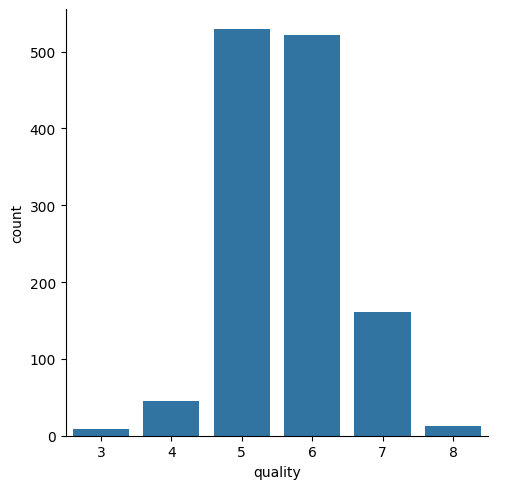

In [18]:
sns.catplot(x="quality",data=df_pandas,kind='count')

<Axes: xlabel='quality', ylabel='volatile acidity'>

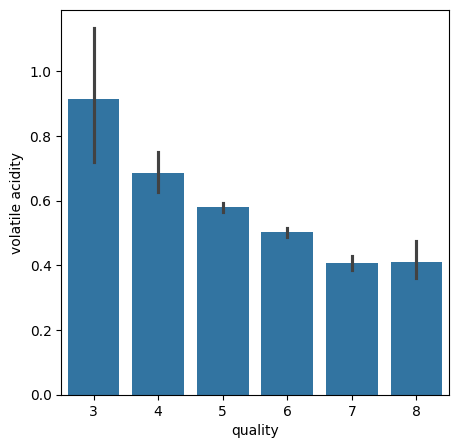

In [23]:
# Relation between label with features 
plot= plt.figure(figsize=(5,5))
sns.barplot(x='quality',y='volatile acidity',data=df_pandas,legend='auto')

<Axes: >

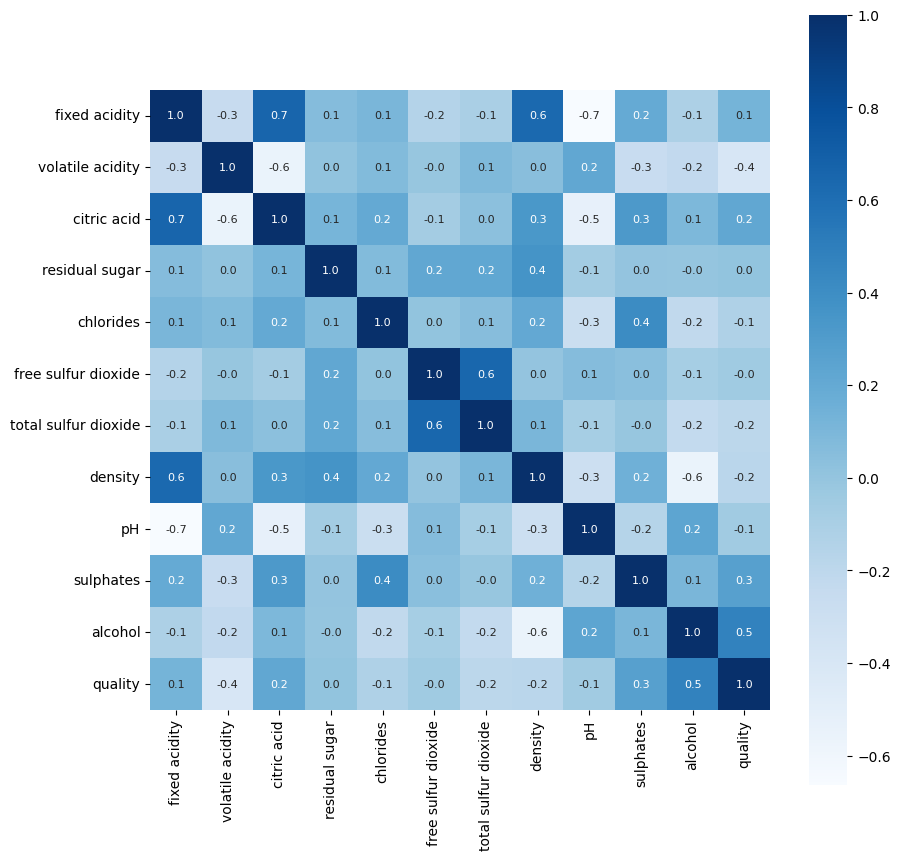

In [25]:
# Find correlation
correlation = df_pandas.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation,cbar=True,square=True,fmt='.1f',annot=True,annot_kws={'size':8},cmap='Blues')

In [19]:
data.describe().show()

24/03/30 03:31:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|summary|    fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|         sulphates|           alcohol|           quality|
+-------+-----------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|  count|             1279|               1279|               1279|              1279|                1279|               1279|                1279|                1279|               1279|              1279|              1279|              1279|
|   mean|8.1

In [21]:
#  Find Outliers

df=data
# List of columns to check for outliers, assuming they are numerical
numerical_columns = [column for (column, dtype) in df.dtypes if dtype in ['int', 'double']]

outliers = {}

for col_name in numerical_columns:
    # Calculate Q1 and Q3
    quantiles = data.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter data for outliers
    outliers_in_col = df.filter((df[col_name] < lower_bound) | (df[col_name] > upper_bound))
    
    # You can collect the results, count them, or even show a few
    outlier_count = outliers_in_col.count()
    print(f"Column {col_name} has {outlier_count} outliers")
    
    # Saving outliers information, for example, as a count
    outliers[col_name] = outlier_count

Column fixed acidity has 61 outliers
Column volatile acidity has 16 outliers
Column citric acid has 1 outliers
Column residual sugar has 126 outliers
Column chlorides has 94 outliers
Column free sulfur dioxide has 25 outliers
Column total sulfur dioxide has 52 outliers
Column density has 39 outliers
Column pH has 24 outliers
Column sulphates has 53 outliers
Column alcohol has 14 outliers
Column quality has 22 outliers


In [4]:
# Data preparation
feature_cols = data.columns[:-1]  # Assuming last column is 'Quality' which is the label
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
labelIndexer = StringIndexer(inputCol="quality", outputCol="label").fit(data)
# Model
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# Pipeline
pipeline = Pipeline(stages=[assembler, labelIndexer, rf])

# Train model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score}")




F1 Score: 0.5493402251239597


In [ ]:
# Save model
model.write().overwrite().save("/workspaces/ml-winequality/model/wine_quality_model")


spark.stop()

In [6]:
df=data
# Assuming you want to normalize all numeric columns
numericCols = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType))]
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

# Min-Max Scaling
minMaxScaler = MinMaxScaler(inputCol="features", outputCol="minMaxScaledFeatures")

# Standard Scaler (Z-score Standardization)
standardScaler = StandardScaler(inputCol="features", outputCol="standardScaledFeatures", withMean=True, withStd=True)

# Pipeline
pipeline = Pipeline(stages=[assembler, minMaxScaler, standardScaler])
model = pipeline.fit(df)
normalized_df = model.transform(df)

# Show results
normalized_df.select("minMaxScaledFeatures", "standardScaledFeatures").show()

+--------------------+----------------------+
|minMaxScaledFeatures|standardScaledFeatures|
+--------------------+----------------------+
|[0.39090909090909...|  [0.46932693965105...|
|[0.27272727272727...|  [-0.3299662105669...|
|[0.30000000000000...|  [-0.1455139451319...|
|[0.35454545454545...|  [0.22339058573783...|
|[0.20909090909090...|  [-0.7603548299150...|
|[0.15454545454545...|  [-1.1292593607848...|
|[0.27272727272727...|  [-0.3299662105669...|
|[0.30000000000000...|  [-0.1455139451319...|
|[0.22727272727272...|  [-0.6373866529584...|
|[0.29090909090909...|  [-0.2069980336102...|
|[0.19090909090909...|  [-0.8833230068716...|
|[0.20909090909090...|  [-0.7603548299150...|
|[0.33636363636363...|  [0.10042240878122...|
|[0.20909090909090...|  [-0.7603548299150...|
|[0.05454545454545...|  [-1.8055843340462...|
|[0.29090909090909...|  [-0.2069980336102...|
|[0.29090909090909...|  [-0.2069980336102...|
|[0.31818181818181...|  [-0.0225457681753...|
|[0.10000000000000...|  [-1.498163

In [7]:
# Define the columns to be used as features and the target column
featureCols = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType)) and field.name != "quality"]
targetCol = "quality"

# Assemble features
assembler = VectorAssembler(inputCols=featureCols, outputCol="assembledFeatures")

# Normalize features using Min-Max Scaling
scaler = MinMaxScaler(inputCol="assembledFeatures", outputCol="normalizedFeatures")

# Initialize the model
model = RandomForestRegressor(featuresCol="normalizedFeatures", labelCol=targetCol)

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, scaler, model])

# Split the dataset into training and test sets
(train_data, test_data) = df.randomSplit([0.7, 0.3])

# Train the model
fitted_pipeline = pipeline.fit(train_data)

# Make predictions
predictions = fitted_pipeline.transform(test_data)

# Select example rows to display
predictions.select("prediction", targetCol, "normalizedFeatures").show(5)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol=targetCol, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

f1_score = evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score}")

+-----------------+-------+--------------------+
|       prediction|quality|  normalizedFeatures|
+-----------------+-------+--------------------+
|6.423570899208815|      6|[0.03636363636363...|
|6.289799122133842|      6|[0.05454545454545...|
|6.177486772828437|      6|[0.05454545454545...|
|5.971855798467381|      6|[0.05454545454545...|
|5.668824041031046|      6|[0.07272727272727...|
+-----------------+-------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.663743430584235
F1 Score: 0.663743430584235


In [8]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="quality", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = fitted_pipeline.stages[1]
print(rfModel)  # summary only

IllegalArgumentException: RegressionEvaluator_4d2eac0dbc55 parameter metricName given invalid value f1.

In [10]:
# Cross Validation 
# Define the columns to be used as features and the target column
featureCols = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType)) and field.name != "quality"]
targetCol = "quality"

# Assemble features
assembler = VectorAssembler(inputCols=featureCols, outputCol="assembledFeatures")

# Normalize features using Min-Max Scaling
scaler = MinMaxScaler(inputCol="assembledFeatures", outputCol="normalizedFeatures")

# Initialize the model
model = RandomForestRegressor(featuresCol="normalizedFeatures", labelCol=targetCol)

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, scaler, model])

# Split the dataset into training and test sets
(train_data, test_data) = df.randomSplit([0.7, 0.3])

# Define a parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30,40]) \
    .addGrid(rf.maxDepth, [5, 10, 15,20]) \
    .build()

# Set up CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="quality"),
                          numFolds=20)

# Fit the models and find the best one
cvModel = crossval.fit(train_data)

# Use the best model to make predictions on the test data
predictions = cvModel.transform(test_data)

# Evaluate the best model
evaluator = RegressionEvaluator(labelCol="quality", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

Root Mean Squared Error (RMSE) on test data: 0.6422903551801724
